Import packages.

In [1]:
import openai
import os
from langchain.chains import LLMChain
from langchain import OpenAI, LLMChain, PromptTemplate
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.evaluation.qa import ContextQAEvalChain
from langchain.memory import ConversationBufferWindowMemory

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
import httpx
import tabulate

/Users/ub8r3a2/VirtualEnvs/llama/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Set up of LLM. 

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")


In [3]:
llm = ChatOpenAI(model="gpt-4o")

/Users/ub8r3a2/VirtualEnvs/llama/lib/python3.9/site-packages/langchain_openai/embeddings/base.py:281: UserWarning: WARNING! user is not default parameter.
                    user was transferred to model_kwargs.
                    Please confirm that user is what you intended.
  warnings.warn(
/Users/ub8r3a2/VirtualEnvs/llama/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3550: UserWarning: WARNING! user is not default parameter.
                user was transferred to model_kwargs.
                Please confirm that user is what you intended.
  exec(code_obj, self.user_global_ns, self.user_ns)


Adding context.

In [4]:
body_1 = """
        Investing in your 20s.
        
        In your 20s, you’re at the very beginning of your adult life. You’re probably embarking on a career, learning to manage expenses and maybe even thinking about buying a condo or house. While retirement probably feels far away, one of the smartest moves you can make financially in your 20s is to start investing for your long-term financial goals.

        There are a few reasons for this. For one thing, starting to invest early means your portfolio can handle more risk and withstand short-term market volatility to generate returns over time. You’ll also reap the benefits of compound growth, boosting your investing power and building a strong foundation for your future.

        One thing to note: Before you invest any money, be sure you won’t need it for living expenses, such as rent, food and utilities. It’s also a good idea to start saving into an  so you’re covered in case of unexpected expenses.

        Here are some tips for how to approach investing in your 20s.

        A potential asset allocation mix when investing in your 20s
        Stocks: 90%
        Bonds: 10%
        Build a financial base
        Two words: . Money you invest in your 20s will benefit from decades of interest. Consider this hypothetical example: $10,000 invested at age 25 — with a 6% return, compounded annually — can net you $109,000 at age 65.

        Be aggressive
        Allocating most of your investments to stocks can be risky, because equity investments are generally more volatile than bonds. But stocks may also have more potential for growth, and in your 20s, your portfolio has more time to recover from any potential losses.

        Join an employer-sponsored retirement plan
        If you have access to one, investing through an , such as a 401(k), SEP or SIMPLE IRA, is the easiest way to save for your future. Contributions are directly withdrawn from your paycheck, and many employers will match those contributions up to a certain amount, too.

        If it’s available, selecting a target date fund option can help keep your asset allocation in line with your age. And don’t forget about your .

        Open an IRA
        If you have a little extra money to invest in your future each month or don’t have access to a 401(k), a traditional individual retirement account (IRA) or Roth IRA is another way to help you save for retirement.

        A  may be a particularly good choice early in your career, and here’s why: Roth accounts are funded with after-tax money, and you can withdraw the earnings tax-free after age 59 1/2. If you’re currently in a lower tax bracket than you expect to be at retirement, investing in a Roth IRA in your 20s could mean you pay less tax on that money overall. 

        Pay down debt
        You should pay off high-interest credit card debt first, but paying off lower-interest student loans may also help you save and invest more in the long run.
        """

body_2 = """
            Investing in your 40s.
            In your 40s, your career is likely well established, and your children, if you have them, might be old enough to start thinking about college. Suddenly, retirement doesn’t seem so far away, even though you may have a couple of decades of work left.

            Now is the time to maximize your retirement savings contributions, if possible, and assess your mix of investments to ensure your level of risk is appropriate for your time of life.

            Consider these strategies when investing in your 40s.

            A potential asset allocation mix when investing in your 40s
            Stocks: 70%
            Bonds: 30%
            Mix in moderate risk
            As your investment portfolio grows, consider allocating more funds to fixed-income investments, such as . Though these may offer less gains, they may also experience less volatility than equities. Lowering your risk slightly in your 40s may help keep you on track for retirement.

            Take full advantage of your 401(k)
            Work to max out your contributions to your employer retirement plan. Make sure you’re taking advantage of an employer match if it’s offered, and if possible, try to contribute  each year. If you have an HSA, consider maxing out your contributions here, as well.
            Broaden your portfolio
            If you’re maxing out contributions to your retirement accounts and have extra income to invest, consider opening a .  

            Pay down your mortgage
            Your mortgage may have many years left on it, but if you have extra money, you could  and reduce what you pay in overall interest. Alternatively, you could keep your mortgage as it is and use that extra money to invest for retirement. You may still have 20+ years of your working life left, and the power of compound interest will boost any extra 401(k) or IRA contributions you make.

"""

body_3 = """
            Investing in your 60s.
            Consider your early 60s a test run for retirement. You’ll want to plan your retirement distributions for maximum tax-efficiency and prepare mentally, and financially, to live on a fixed income. Before and after retirement, your investments should also be fairly low risk to ensure you have the retirement income that works for your lifestyle.

            Read on for tips for investing in your 60s. 

            A potential asset allocation mix when investing in your 60s
            Stocks: 50%
            Bonds: 40%
            Cash and cash equivalents: 10%
            Maintain low risk
            You may want to include more fixed-income bonds and even cash and cash equivalents (such as certificates of deposits (CDs) and money market accounts) in your investment mix to lower your market risk and create a steady income for your distributions. However, keeping some money in stocks can help keep your portfolio diversified and protect your savings from the impact of inflation.

            Plan your retirement income withdrawal strategy
            While the “4% rule” may be the most common strategy, how you  isn’t a one-size-fits-all solution. Make sure to factor taxes, other income sources and life expectancy into your plan.

            If you’re able, try living off your projected income for a few months prior to retirement to see if your strategy will work for you long-term.     

            Consider your legacy and next generations
            Well before your 60s, and especially if you have dependents, you should have the , such as your will and other estate documents. Make sure to review your estate plan regularly or after a major life event to ensure it still meets your intentions.

             Once you’ve reached retirement, starting your wealth transfer and yearly charitable giving may help lower the tax burden for your estate.

"""

Define data objects:
OverallState and FinalAnswerState are the State objects.
Answer and FinalAnswer are data schemas for answer generation.

In [5]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class OverallState(TypedDict):
    question: str
    contexts: list
    perspective: str    
    perspectives: list
    
    answers: Annotated[list, operator.add] 
    
class FinalAnswerState(TypedDict):
    all_inclusive_answer: str
    
class Answer(BaseModel):
    answer: str = Field(
        description="Answer to user's question.",
    )
        
class FinalAnswer(BaseModel):
    final_answer: str = Field(
        description="Comprehensive answer to user's question.",
    )

Define functions for our graph nodes and edges.

Implements map-reduce concepts by sending every combination of perspective and context to the generate_answer node.

In [6]:
from langgraph.constants import Send

def continue_to_answers(state):
    return [Send ("generate_answer", {"question": state["question"], "context": c, "perspective": p}) for c in state["contexts"] for p in state["perspectives"]]



Call to LLM to generate a contex based answer from the point of each perspective.

In [7]:
def generate_answer(state):
    answer_prompt = """Based only on {context} generate answer to the {question} for the perspective {perspective}"""
    prompt = answer_prompt.format(context=state["context"], question = state["question"], perspective = state["perspective"])
    
    response = llm.with_structured_output(Answer).invoke(prompt)
    return {"answers": [response.answer]}

Call to LLM asking to generate comprehensive answer based on a list of perspective based answers from all the given contexts.

In [8]:
def comprehensive_answer(state):
    
    comprehensive_answer_prompt = """Below is a list of answers to the {question}.
                                     Each answer is formulated for a specific perspective from the list of {perspectives}. 
                                     Based on those answers, create one comprehensive answer. 
                                     Answers: \n\n  {answers}"""
    prompt = comprehensive_answer_prompt.format(question = state["question"], perspectives = state["perspectives"], answers = state["answers"])
    response = llm.with_structured_output(FinalAnswer).invoke(prompt)
    return {"all_inclusive_answer": response.final_answer}
    

In [ ]:
Define our graph.

/var/folders/m7/hcqxm0r55vj2b2c8gv3nxtkchy1kzp/T/ipykernel_22088/2323624567.py:6: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  graph = StateGraph(input = OverallState, output = FinalAnswerState)


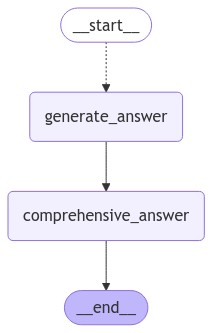

In [9]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph

graph = StateGraph(input = OverallState, output = FinalAnswerState)
graph.add_conditional_edges(START, continue_to_answers, ["generate_answer"])
graph.add_node("generate_answer", generate_answer)
graph.add_node("comprehensive_answer", comprehensive_answer)
graph.add_edge("generate_answer", "comprehensive_answer")
graph.add_edge("comprehensive_answer", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

InvestorProfile class describes investment perspective.

In [10]:
class InvestorProfile(BaseModel):
    age: str = Field(
        description="Investor's age.",
    )
    investment: str = Field(
        description="Dollar amount of investment capital."
    )
    risk: str = Field(
        description="How much risk investor wants to take.",
    )
    
    @property
    def persona(self) -> str:
        return f"My age is: {self.age}\n My investment capital: {self.investment}\n My risk profile: {self.risk}\n"


Invoke graph with a list of perspectives and contexts.
Each perspective is defined by the instance of the InvestorProfile class.

In [11]:
import time
start_time = time.time()

perspective_one = InvestorProfile(age = "21 years old", investment = "5000 dollars", risk = "I am ok with taking financial risk.")
perspective_two = InvestorProfile(age = "45 years old", investment = "300000 dollars", risk = "I am only willing to take minimal financial risk.")
perspective_three = InvestorProfile(age = "67 years old", investment = "1000000 dollars", risk = "I do not want to take any financial risk.")

input = {"question": "What is the best way to invest my money?", "perspectives": [perspective_one.persona, perspective_two.persona, perspective_three.persona], "contexts": [body_1, body_2, body_3]}
response = app.invoke(input)
print("------------- %s seconds -------------" % (time.time() - start_time))

print("**************************")
print(response["all_inclusive_answer"])
print("**************************")

------------- 1.8238062858581543 seconds -------------
**************************
Given the diverse age groups, investment capital, and risk profiles, here is a comprehensive investment strategy tailored to different scenarios:

1. **Young Investors (21 years old, $5,000, High Risk Tolerance):**
   - **Build a Financial Base:** Ensure you have an emergency fund covering 3-6 months of living expenses.
   - **Aggressive Asset Allocation:** Consider a mix of 90% stocks and 10% bonds to capitalize on growth potential.
   - **Invest in Stocks:** Use index funds or ETFs for diversification and broad market exposure.
   - **Retirement Accounts:** Contribute to a 401(k) if available and open a Roth IRA for tax-free growth.
   - **Pay Down Debt:** Prioritize paying off high-interest debt.
   - **Continuous Learning:** Educate yourself about investing and adjust your strategy as needed.

2. **Mid-Life Investors (45 years old, $300,000, Minimal Risk Tolerance):**
   - **Diversified Portfolio:** A

In [ ]:
import time
start_time = time.time()

input = {"question": "What is the best way to invest my money?", "perspectives": ["I am 21 years old", "I am 45 years old", "I am 61 years old."], "contexts": [body_1, body_2, body_3]}
response = app.invoke(input)
print("------------- %s seconds -------------" % (time.time() - start_time))

print("**************************")
print(response["all_inclusive_answer"])
print("**************************")

In [ ]:
import time
start_time = time.time()

input = {"question": "What are the tax disadvantages of contributing to a retirement account?", "perspectives": ["I am 21 years old", "I am 45 years old", "I am 61 years old."], "contexts": [body_1, body_2, body_3]}
response = app.invoke(input)
print("------------- %s seconds -------------" % (time.time() - start_time))

print("**************************")
print(response["all_inclusive_answer"])
print("**************************")